In [9]:
import math
import os
import sys
from typing import Iterable
import numpy as np
import copy
import itertools
import argparse

import numpy as np
import json
import cv2
from PIL import Image

import torch
import torchvision
import torchvision.transforms as T

import util.misc as utils
from datasets.coco_eval import CocoEvaluator
from datasets.panoptic_eval import PanopticEvaluator
from datasets.hico_eval import HICOEvaluator
from datasets.vcoco_eval import VCOCOEvaluator
from models import build_model
from datasets import build_dataset

from bounding_box import bounding_box as bb

In [34]:
parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
parser.add_argument('--lr', default=1e-4, type=float)
parser.add_argument('--lr_backbone', default=1e-5, type=float)
parser.add_argument('--batch_size', default=2, type=int)
parser.add_argument('--weight_decay', default=1e-4, type=float)
parser.add_argument('--epochs', default=150, type=int)
parser.add_argument('--lr_drop', default=100, type=int)
parser.add_argument('--clip_max_norm', default=0.1, type=float,
                    help='gradient clipping max norm')

# Model parameters
parser.add_argument('--frozen_weights', type=str, default=None,
                    help="Path to the pretrained model. If set, only the mask head will be trained")
# * Backbone
parser.add_argument('--backbone', default='resnet50', type=str,
                    help="Name of the convolutional backbone to use")
parser.add_argument('--dilation', action='store_true',
                    help="If true, we replace stride with dilation in the last convolutional block (DC5)")
parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                    help="Type of positional embedding to use on top of the image features")

# * Transformer
parser.add_argument('--enc_layers', default=6, type=int,
                    help="Number of encoding layers in the transformer")
parser.add_argument('--dec_layers', default=6, type=int,
                    help="Number of decoding layers in the transformer")
parser.add_argument('--dim_feedforward', default=2048, type=int,
                    help="Intermediate size of the feedforward layers in the transformer blocks")
parser.add_argument('--hidden_dim', default=256, type=int,
                    help="Size of the embeddings (dimension of the transformer)")
parser.add_argument('--dropout', default=0.1, type=float,
                    help="Dropout applied in the transformer")
parser.add_argument('--nheads', default=8, type=int,
                    help="Number of attention heads inside the transformer's attentions")
parser.add_argument('--num_queries', default=100, type=int,
                    help="Number of query slots")
parser.add_argument('--pre_norm', action='store_true')

# * Segmentation
parser.add_argument('--masks', action='store_true',
                    help="Train segmentation head if the flag is provided")

# HOI
parser.add_argument('--hoi', action='store_true',
                    help="Train for HOI if the flag is provided")
parser.add_argument('--num_obj_classes', type=int, default=80,
                    help="Number of object classes")
parser.add_argument('--num_verb_classes', type=int, default=117,
                    help="Number of verb classes")
parser.add_argument('--pretrained', type=str, default='',
                    help='Pretrained model path')
parser.add_argument('--subject_category_id', default=0, type=int)
parser.add_argument('--verb_loss_type', type=str, default='focal',
                    help='Loss type for the verb classification')

# Loss
parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                    help="Disables auxiliary decoding losses (loss at each layer)")
# * Matcher
parser.add_argument('--set_cost_class', default=1, type=float,
                    help="Class coefficient in the matching cost")
parser.add_argument('--set_cost_bbox', default=5, type=float,
                    help="L1 box coefficient in the matching cost")
parser.add_argument('--set_cost_giou', default=2, type=float,
                    help="giou box coefficient in the matching cost")
parser.add_argument('--set_cost_obj_class', default=1, type=float,
                    help="Object class coefficient in the matching cost")
parser.add_argument('--set_cost_verb_class', default=1, type=float,
                    help="Verb class coefficient in the matching cost")

# * Loss coefficients
parser.add_argument('--mask_loss_coef', default=1, type=float)
parser.add_argument('--dice_loss_coef', default=1, type=float)
parser.add_argument('--bbox_loss_coef', default=5, type=float)
parser.add_argument('--giou_loss_coef', default=2, type=float)
parser.add_argument('--obj_loss_coef', default=1, type=float)
parser.add_argument('--verb_loss_coef', default=1, type=float)
parser.add_argument('--eos_coef', default=0.1, type=float,
                    help="Relative classification weight of the no-object class")

# dataset parameters
parser.add_argument('--dataset_file', default='coco')
parser.add_argument('--coco_path', type=str)
parser.add_argument('--coco_panoptic_path', type=str)
parser.add_argument('--remove_difficult', action='store_true')
parser.add_argument('--hoi_path', type=str)

parser.add_argument('--output_dir', default='',
                    help='path where to save, empty for no saving')
parser.add_argument('--device', default='cuda',
                    help='device to use for training / testing')
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--resume', default='', help='resume from checkpoint')
parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                    help='start epoch')
parser.add_argument('--eval', action='store_true')
parser.add_argument('--num_workers', default=2, type=int)

# distributed training parameters
parser.add_argument('--world_size', default=1, type=int,
                    help='number of distributed processes')
parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')


args = argparse.Namespace(
  seed=0,
  no_gpus=True,
  f_lambda=None
)

In [35]:
args = parser.parse_args(args=['--pretrained', '/hub_data3/intern/seokwon/qpic/logs/qpic_resnet50_vcoco.pth',
                               '--hoi', '--dataset_file', 'vcoco', '--hoi_path',
                               '/hub_data3/intern/seokwon/qpic/data/v-coco', '--num_obj_classes', '81',
                               '--num_verb_classes', '29', '--backbone', 'resnet50', '--eval'])

origin, criterion, postprocessors = build_model(args)
origin.to('cuda')
checkpoint = torch.load(args.pretrained, map_location='cpu')
origin.load_state_dict(checkpoint['model'], strict=False)
origin.eval()

DETRHOI(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
    

In [36]:
args = parser.parse_args(args=['--pretrained', '/hub_data3/intern/seokwon/qpic/logs/checkpoint.pth',
                               '--hoi', '--dataset_file', 'vcoco', '--hoi_path',
                               '/hub_data3/intern/seokwon/qpic/data/v-coco', '--num_obj_classes', '81',
                               '--num_verb_classes', '29', '--backbone', 'resnet50', '--eval'])

denoised, criterion, postprocessors = build_model(args)
denoised.to('cuda')
checkpoint = torch.load(args.pretrained, map_location='cpu')
denoised.load_state_dict(checkpoint['model'], strict=False)
denoised.eval()

DETRHOI(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
    

In [37]:
val = build_dataset('val', args)

In [103]:
im = dict()
for i, ano in enumerate(val.annotations):
    bicycle = False
    for a in ano['annotations']:
        if a['category_id'] == 4:
            bicycle = True
            break
    if bicycle:
        im[i] = ano['file_name']

In [104]:
object_label = [
    'no_object', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', \
    'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', \
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', \
    'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', \
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', \
    'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', \
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', \
    'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', \
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', \
    'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']

verb_label = [
    'hold_obj', 'stand', 'sit_instr', 'ride_instr', 'walk', 'look_obj', 'hit_instr', 'hit_obj', \
    'eat_obj', 'eat_instr', 'jump_instr', 'lay_instr', 'talk_on_phone_instr', 'carry_obj', \
    'throw_obj', 'catch_obj', 'cut_instr', 'cut_obj', 'run', 'work_on_computer_instr', \
    'ski_instr', 'surf_instr', 'skateboard_instr', 'smile', 'drink_instr', 'kick_obj', \
    'point_instr', 'read_obj', 'snowboard_instr']

i2o = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,
   14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
   24, 25, 27, 28, 31, 32, 33, 34, 35, 36,
   37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
   48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
   58, 59, 60, 61, 62, 63, 64, 65, 67, 70,
   72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
   82, 84, 85, 86, 87, 88, 89, 90]

In [105]:
im

{16: 'COCO_val2014_000000363272.jpg',
 23: 'COCO_val2014_000000543547.jpg',
 30: 'COCO_val2014_000000292456.jpg',
 31: 'COCO_val2014_000000528962.jpg',
 33: 'COCO_val2014_000000064240.jpg',
 36: 'COCO_val2014_000000050713.jpg',
 54: 'COCO_val2014_000000349437.jpg',
 57: 'COCO_val2014_000000464515.jpg',
 58: 'COCO_val2014_000000183166.jpg',
 66: 'COCO_val2014_000000550968.jpg',
 78: 'COCO_val2014_000000506335.jpg',
 102: 'COCO_val2014_000000392392.jpg',
 109: 'COCO_val2014_000000027611.jpg',
 121: 'COCO_val2014_000000492885.jpg',
 130: 'COCO_val2014_000000445041.jpg',
 141: 'COCO_val2014_000000012744.jpg',
 151: 'COCO_val2014_000000432623.jpg',
 153: 'COCO_val2014_000000310553.jpg',
 155: 'COCO_val2014_000000363048.jpg',
 158: 'COCO_val2014_000000087920.jpg',
 164: 'COCO_val2014_000000573214.jpg',
 173: 'COCO_val2014_000000050431.jpg',
 182: 'COCO_val2014_000000178982.jpg',
 193: 'COCO_val2014_000000038829.jpg',
 201: 'COCO_val2014_000000377352.jpg',
 210: 'COCO_val2014_000000070744.jpg

Original QPIC : Person 72 Interactions : ['sit_instr', 'ride_instr']


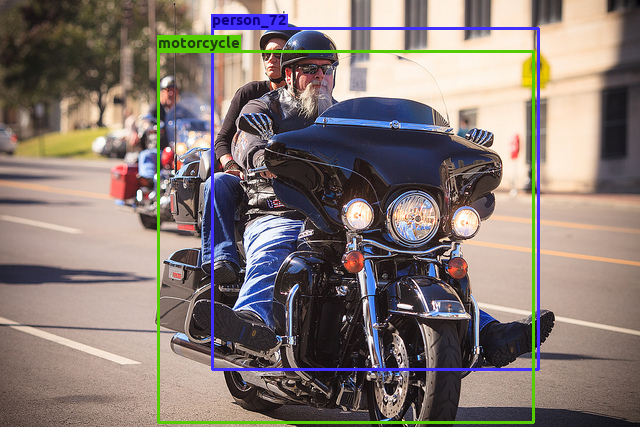

In [106]:
file_idx = 640

file_name = im[file_idx]

samples, targets = val.__getitem__(file_idx)
samples = samples[None, :, :, :].to('cuda')
outputs = origin(samples)
orig_target_sizes = torch.stack([targets["orig_size"]], dim=0)
results = postprocessors['hoi'](outputs, orig_target_sizes)
ve = VCOCOEvaluator(results, [targets], args.subject_category_id, val.correct_mat)
preds = ve.preds[0]
final = []
for pred in preds['hoi_prediction']:
    if pred['score'] > 0.5:
        final.append(pred)
        
        
im_dir = '/hub_data3/intern/seokwon/qpic/data/v-coco/images/val2014/{}'.format(file_name)
img = Image.open(im_dir)
img = np.array(img)

h_dic = dict()
for fin in final:
    sub = fin['subject_id']
    obj = fin['object_id']
    
    sub_box = preds['predictions'][sub]['bbox']
    obj_box = preds['predictions'][obj]['bbox']
    obj_cls = preds['predictions'][obj]['category_id']
    verb = fin['category_id']
    verb_cls = verb_label[verb]
    
    if obj_cls == 80:
        continue
    
    if sub in h_dic:
        h_dic[sub].append(verb_cls)
    else:
        h_dic[sub] = [verb_cls]
    
    bb.add(img, sub_box[0], sub_box[1], sub_box[2], sub_box[3], "person_{}".format(sub), "red")
    bb.add(img, obj_box[0], obj_box[1], obj_box[2], obj_box[3], object_label[i2o[obj_cls]], "green")
    
for idx, verb_list in h_dic.items():
    print("Original QPIC : Person {} Interactions : ".format(idx), end='')
    print(verb_list)
Image.fromarray(img)

Denoised QPIC : Person 98 Interactions : ['sit_instr', 'ride_instr']
Denoised QPIC : Person 67 Interactions : ['sit_instr', 'ride_instr']


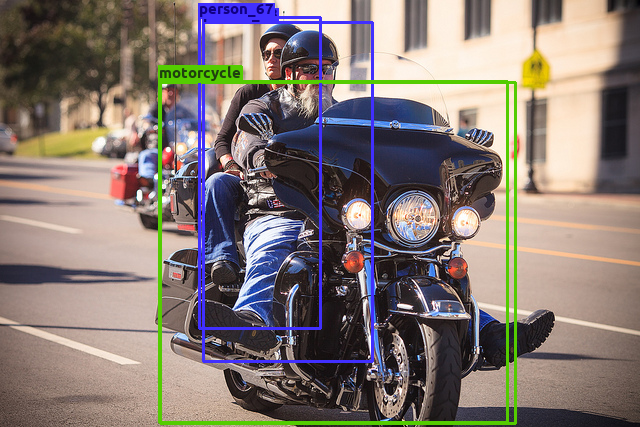

In [107]:
file_name = im[file_idx]

samples, targets = val.__getitem__(file_idx)
samples = samples[None, :, :, :].to('cuda')
outputs = denoised(samples)
orig_target_sizes = torch.stack([targets["orig_size"]], dim=0)
results = postprocessors['hoi'](outputs, orig_target_sizes)
ve = VCOCOEvaluator(results, [targets], args.subject_category_id, val.correct_mat)
preds = ve.preds[0]
final = []
for pred in preds['hoi_prediction']:
    if pred['score'] > 0.5:
        final.append(pred)
        
        
im_dir = '/hub_data3/intern/seokwon/qpic/data/v-coco/images/val2014/{}'.format(file_name)
img = Image.open(im_dir)
img = np.array(img)

h_dic = dict()
for fin in final:
    sub = fin['subject_id']
    obj = fin['object_id']
    
    sub_box = preds['predictions'][sub]['bbox']
    obj_box = preds['predictions'][obj]['bbox']
    obj_cls = preds['predictions'][obj]['category_id']
    verb = fin['category_id']
    verb_cls = verb_label[verb]
    
    if obj_cls == 80:
        continue
    
    if sub in h_dic:
        h_dic[sub].append(verb_cls)
    else:
        h_dic[sub] = [verb_cls]
    
    bb.add(img, sub_box[0], sub_box[1], sub_box[2], sub_box[3], "person_{}".format(sub), "red")
    bb.add(img, obj_box[0], obj_box[1], obj_box[2], obj_box[3], object_label[i2o[obj_cls]], "green")
for idx, verb_list in h_dic.items():
    print("Denoised QPIC : Person {} Interactions : ".format(idx), end='')
    print(verb_list)
Image.fromarray(img)

GT : Person 3 Interactions : ['hold_obj', 'sit_instr', 'ride_instr']
GT : Person 2 Interactions : ['sit_instr', 'ride_instr']


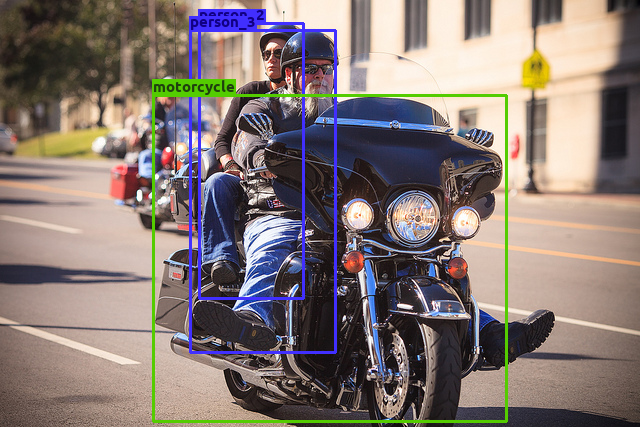

In [115]:
file_name = im[file_idx]

samples, targets = val.__getitem__(file_idx)
        
im_dir = '/hub_data3/intern/seokwon/qpic/data/v-coco/images/val2014/{}'.format(file_name)
img = Image.open(im_dir)
img = np.array(img)

h_dic = dict()
for hoi in targets['hois']:
    sub = hoi[0].item()
    obj = hoi[1].item()
    verb = hoi[2].item()
    sub_box = targets['boxes'][sub, :]
    obj_box = targets['boxes'][obj, :]
    obj_cls = targets['labels'][obj].item()
    
    verb_cls = verb_label[verb]
    
    if obj_cls == 80:
        continue
    
    if sub in h_dic:
        h_dic[sub].append(verb_cls)
    else:
        h_dic[sub] = [verb_cls]
    
    bb.add(img, sub_box[0], sub_box[1], sub_box[2], sub_box[3], "person_{}".format(sub), "red")
    bb.add(img, obj_box[0], obj_box[1], obj_box[2], obj_box[3], object_label[i2o[obj_cls]], "green")
    
for idx, verb_list in h_dic.items():
    print("GT : Person {} Interactions : ".format(idx), end='')
    print(verb_list)
Image.fromarray(img)

In [108]:
targets

{'orig_size': tensor([427, 640]),
 'size': tensor([427, 640]),
 'boxes': tensor([[1.5353e+02, 9.5000e+01, 5.0664e+02, 4.2124e+02],
         [1.0920e+02, 9.1740e+01, 2.2197e+02, 2.3083e+02],
         [1.9959e+02, 2.3990e+01, 3.0322e+02, 2.9842e+02],
         [1.9093e+02, 3.0810e+01, 3.3574e+02, 3.5221e+02],
         [1.3745e+02, 7.5170e+01, 1.8035e+02, 1.9066e+02],
         [4.5721e+02, 1.1772e+02, 4.7064e+02, 1.3895e+02],
         [1.7202e+02, 1.4775e+02, 2.2487e+02, 2.3091e+02],
         [5.0996e+02, 1.3499e+02, 5.1915e+02, 1.5910e+02],
         [9.1040e+01, 1.2794e+02, 1.2695e+02, 1.5761e+02],
         [1.0000e-01, 1.2293e+02, 1.7720e+01, 1.5494e+02]]),
 'labels': tensor([ 3,  3,  0,  0,  0,  0,  3, 12,  2,  2]),
 'id': 640,
 'img_id': 131494,
 'hois': tensor([[3, 0, 0],
         [2, 0, 2],
         [3, 0, 2],
         [2, 0, 3],
         [3, 0, 3]])}